In [150]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [151]:
import numpy as np
import pandas as pd

In [152]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [153]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [154]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [155]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [156]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [157]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [158]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

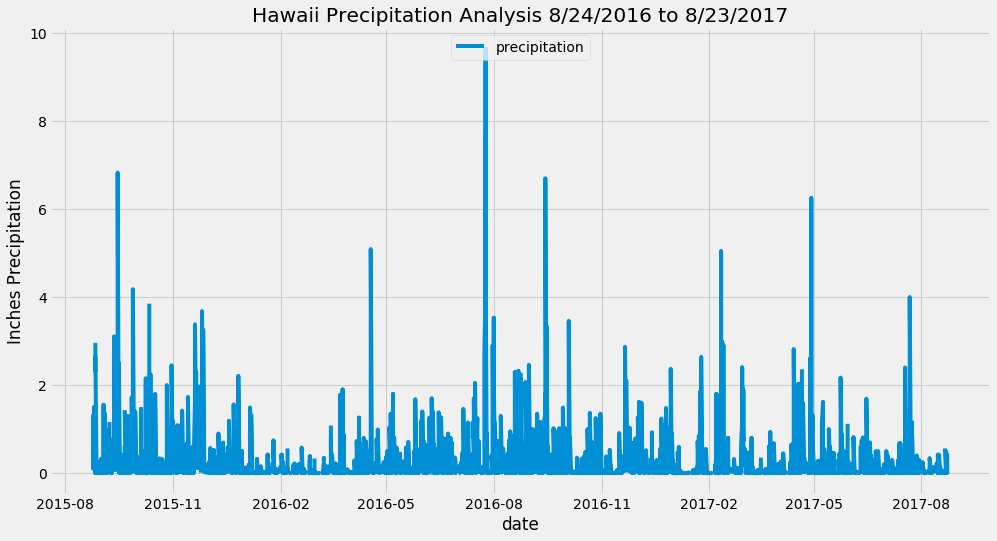

In [159]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
greatest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date_diff = dt.date(2016, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > date_diff) \
                    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df = pd.DataFrame(precipitation_data)
precipitation_data_df['date'] = pd.to_datetime(precipitation_data_df["date"],format='%Y-%m-%d')
precipitation_data_df.set_index("date",inplace=True)

# Sort the dataframe by date
precipitation_data_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,8))
plt.plot(precipitation_data_df.index,precipitation_data_df["prcp"])
plt.xlabel("date")
plt.ylabel("Inches Precipitation")
plt.title("Hawaii Precipitation Analysis 8/24/2016 to 8/23/2017")
plt.legend(["precipitation"],loc='upper center')
plt.savefig("Resources/Precipitation_Analysis.png")
plt.show()


In [160]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data_df.describe()

prcp
count  4085.000000
mean      0.201968
std       0.516756
min       0.000000
25%       0.000000
50%       0.020000
75%       0.160000
max       9.640000

![describe](Images/describe.png)

In [161]:
# Design a query to show how many stations are available in this dataset?
station_Count = session.query(func.count(Station.name)).all()
station_Count

[(9)]

In [162]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
max_stations = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
max_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [163]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Details = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs),Measurement.station).\
          group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
Details

(54.0, 85.0, 71.66378066378067, 'USC00519281')

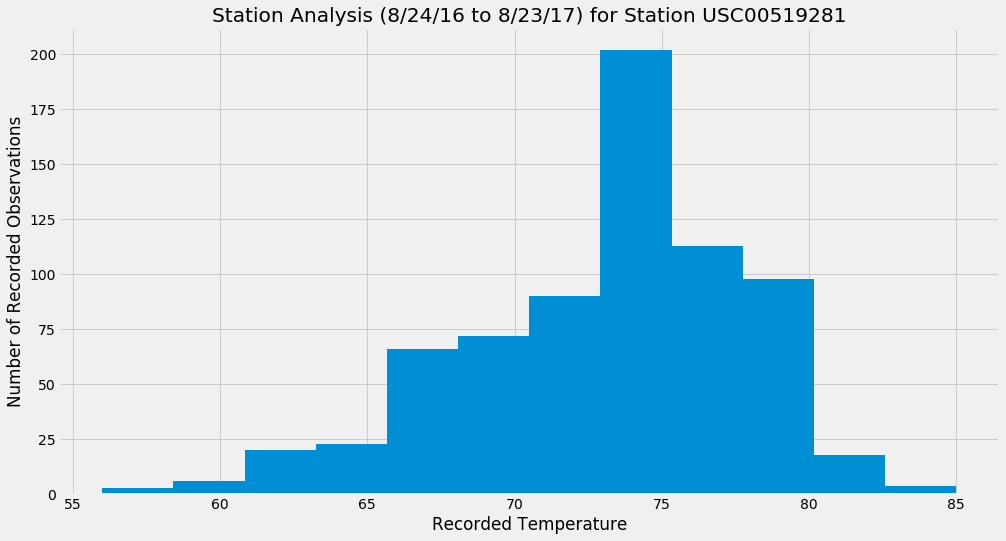

In [164]:
# Choose the station with the highest number of temperature observations.
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).first()
busiest = busy_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > date_diff).\
    order_by(Measurement.date).all()
temp_df=pd.DataFrame(temperature)
plt.figure(figsize=(15,8))
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.savefig("Resources/Station_Analysis.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [165]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [166]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2016, 8, 24)
trip_leave = dt.date(2016, 9, 7)
last_year = dt.timedelta(days=365)
temp_detail = calc_temps((trip_arrive-last_year), (trip_leave-last_year))
print(temp_detail)

[(72.0, 78.88349514563107, 86.0)]


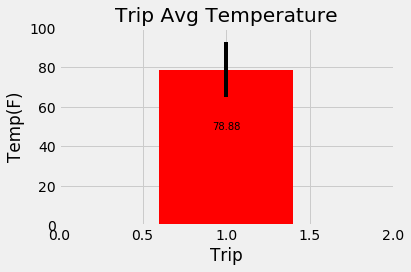

In [167]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
p2p = temp_detail[0][2]-temp_detail[0][0]
avgtemp = temp_detail[0][1]
min_temp = temp_detail[0][0]
max_temp = temp_detail[0][2]


fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp(F)")
ax.set_title("Trip Avg Temperature")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
# label the bars 
autolabels(bar_chart) 
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.savefig("Resources/Trip_avg_temp.png")
plt.show()

In [168]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
vacation_data = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation,Measurement.prcp).\
    filter(Measurement.date >= lst_year_arrive).\
    filter(Measurement.date <= lst_year_leave).\
    filter(Measurement.station==Station.station).\
    order_by((Measurement.prcp).desc()).all()
vacation_data

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.67),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.29),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.55),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 1.5),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.35),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  1.3),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.16),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.04),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.03),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.97),
 ('USC00519523',
  

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


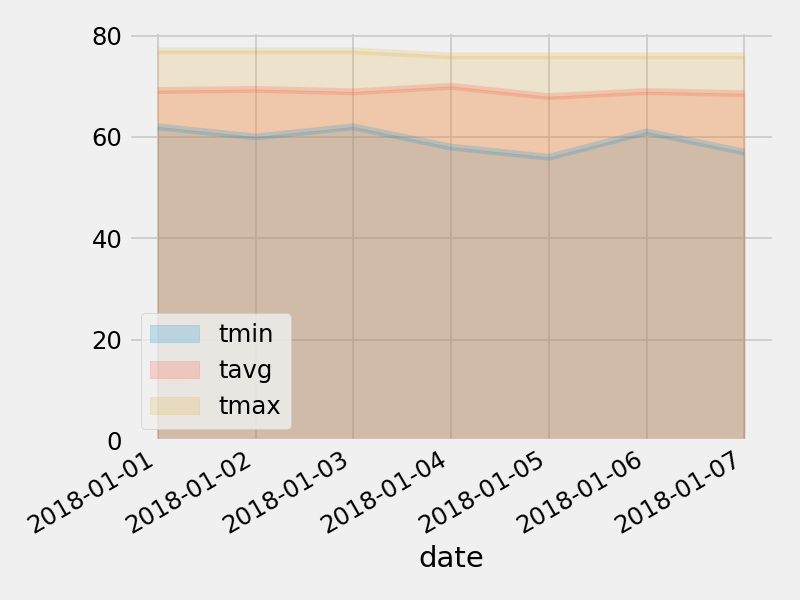

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
